In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import flwr
import torch
import dotenv
import os

from torch.optim.lr_scheduler import CosineAnnealingLR

from fl_g13.fl_pytorch import build_fl_dependencies

from fl_g13.fl_pytorch.editing import load_or_create_centralized_mask
from fl_g13.modeling import load_or_create

from fl_g13.editing.masking import mask_dict_to_list

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM

2025-06-20 11:28:16.469 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: C:\Users\ciovi\Desktop\coding\mldl\fl-g13
c:\Users\ciovi\Desktop\coding\mldl\fl-g13\.venv\lib\site-packages\dockerpycreds\utils.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [3]:
dotenv.load_dotenv()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

build_fl_dependencies()

Training on cuda
Flower 1.17.0 / PyTorch 2.7.1+cu128
'vision_transformer.py' already exists.
'utils.py' already exists.


In [4]:
CHECKPOINT_DIR = dotenv.dotenv_values()['CHECKPOINT_DIR']

J = 8
partition_type = 'shard'
shards = 50
strategy = 'sum'
mask_type = 'local'
mask_sparsity = 0.7
mask_rounds = 3

mask_name = f'{shards}_{J}_{strategy}_mask_{mask_type}_{mask_sparsity}_{mask_rounds}.pth'
file_name = CHECKPOINT_DIR + '/masks/' + mask_name

partition_name = 'iid' if partition_type == 'iid' else 'non_iid'
model_save_path = CHECKPOINT_DIR + f"/fl_dino_v4/{partition_name}/{shards}_{J}"
model_config={
    "head_layers": 3,
    "head_hidden_size": 512,
    "dropout_rate": 0.0,
    "unfreeze_blocks": 0,
}

model, start_epoch = load_or_create(
    path=model_save_path,
    model_class=BaseDino,
    model_config=None,
    optimizer=None,
    scheduler=None,
    device=DEVICE,
)
model.to(DEVICE)

unfreeze_blocks = 12
model.unfreeze_blocks(unfreeze_blocks)
# optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)

# Create a dummy mask for SparseSGDM
# Must be done AFTER the model is moved to the device
init_mask = [torch.ones_like(p, device=p.device) for p in model.parameters()]

# Optimizer, scheduler, and loss function
optimizer = SparseSGDM(
    model.parameters(),
    mask=init_mask,
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-5
)
criterion = torch.nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=8,
    eta_min=1e-5
)

Using cache found in C:\Users\ciovi/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\ciovi/.cache\torch\hub\facebookresearch_dino_main


✅ Loaded checkpoint from /Users/ciovi/Desktop/coding/mldl/fl-g13/checkpoints/fl_dino_v4/non_iid/50_8\fl_fl_baseline_BaseDino_epoch_200_noniid_50_8.pth, resuming at epoch 201


In [5]:
sum_mask, _ = load_or_create_centralized_mask(
    model = model,
    strategy = strategy,
    aggregation_fn = None,
    client_partition_type = partition_type,
    client_num_shards_per_partition = shards,
    client_local_steps = J,
    
    sparsity = mask_sparsity,
    mask_type = mask_type,
    mask_rounds = mask_rounds,
    
    file_name = file_name,
    verbose = True
)
sum_mask = mask_dict_to_list(model, sum_mask)

[CENTR_MASK] Found /Users/ciovi/Desktop/coding/mldl/fl-g13/checkpoints/masks/50_8_sum_mask_local_0.7_3.pth. Loading mask from memory


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sparsity_over_quorum_plot(sum_mask, mask_name):
    def compute_sparsity_given_quorum(mask, quorum):
        assert 0 < quorum <= 100
        
        global_mask = [(layer_sum >= quorum).float() for layer_sum in mask]
        total_params = sum(np.prod(layer.shape) for layer in global_mask)
        total_non_zero = sum(layer.cpu().numpy().nonzero()[0].size for layer in global_mask)
        return 1.0 - (total_non_zero / total_params)

    all_sparsity = [compute_sparsity_given_quorum(sum_mask, quorum) for quorum in range(1, 101)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 101), all_sparsity, '-')
    plt.xlabel('Quorum')
    plt.ylabel('Sparsity')
    plt.title(mask_name)
    plt.grid(True)
    plt.show()

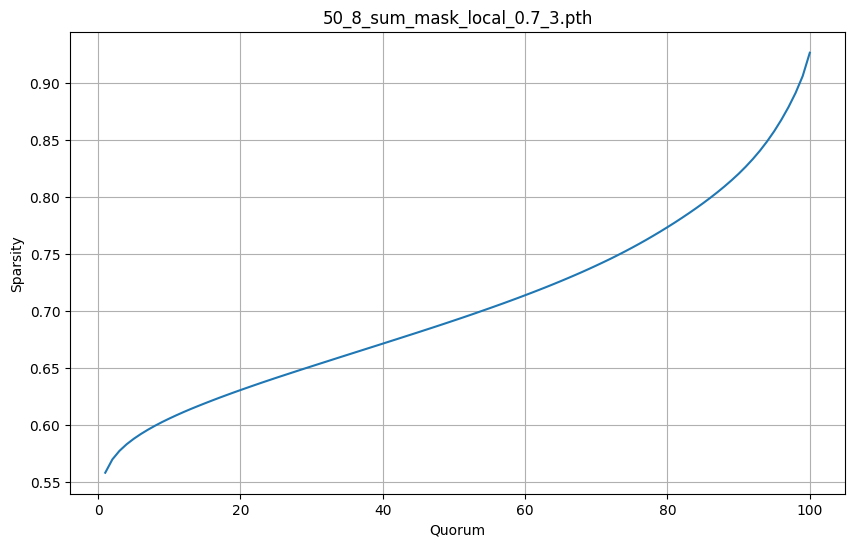

In [7]:
sparsity_over_quorum_plot(sum_mask, mask_name)